# **Instalation des packages et librairies**


Installation de pyspark

In [1]:
! pip install pyspark

In [2]:
#Import des modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from pyspark.sql import SparkSession
from pyspark.sql.functions import col , count , when
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation  import BinaryClassificationEvaluator



# **Creation de notre Session Spark**

In [3]:
Spark = SparkSession.builder.appName('Customer_Churn_Prediction').getOrCreate()

# **Chargement du Dataset**

In [5]:
#loading our data
df = Spark.read.csv("/content/dataset.csv", header = True, inferSchema  =True)
df.show(5)


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [6]:
#Data type
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
#Dimension of our dataset
df.count()

7043

In [8]:
#Number of collumns
len(df.columns)

21

# **Exploraty Data Analysis (EDA)**

Definir des listes pour Stocker chaque colonne avec leur types

In [9]:
df.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [10]:
#Colonne ayant des valeurs numeriques
numerical_cols =[col for col,typ in df.dtypes if typ =='double' or typ=='int']
#Colonne ayant des valeurs categorielles
categorical_cols =[col for col,typ in df.dtypes if typ =='string']
df.select(numerical_cols).show(5)
df.select(categorical_cols).show(5)

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
+------+--------------+------------+
only showing top 5 rows

+----------+------+-------------+-------+----------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|Churn|
+----------+------+-------------+-------+----------+------------+----------------+---------------+--------------+------------+----------------+-----------+-

Stockage des donnees numerique dans un dataFrame

In [11]:
df_numerical = df.select(numerical_cols).toPandas()
df_numerical.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [12]:
#Resumer statistique
df_numerical.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.435752,64.761692,2283.300441
std,25.075228,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,458.000000,118.750000,8684.800000


<ipython-input-13-c42e6febfe87>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_numerical.hist(ax = ax,bins = 20, color="g")


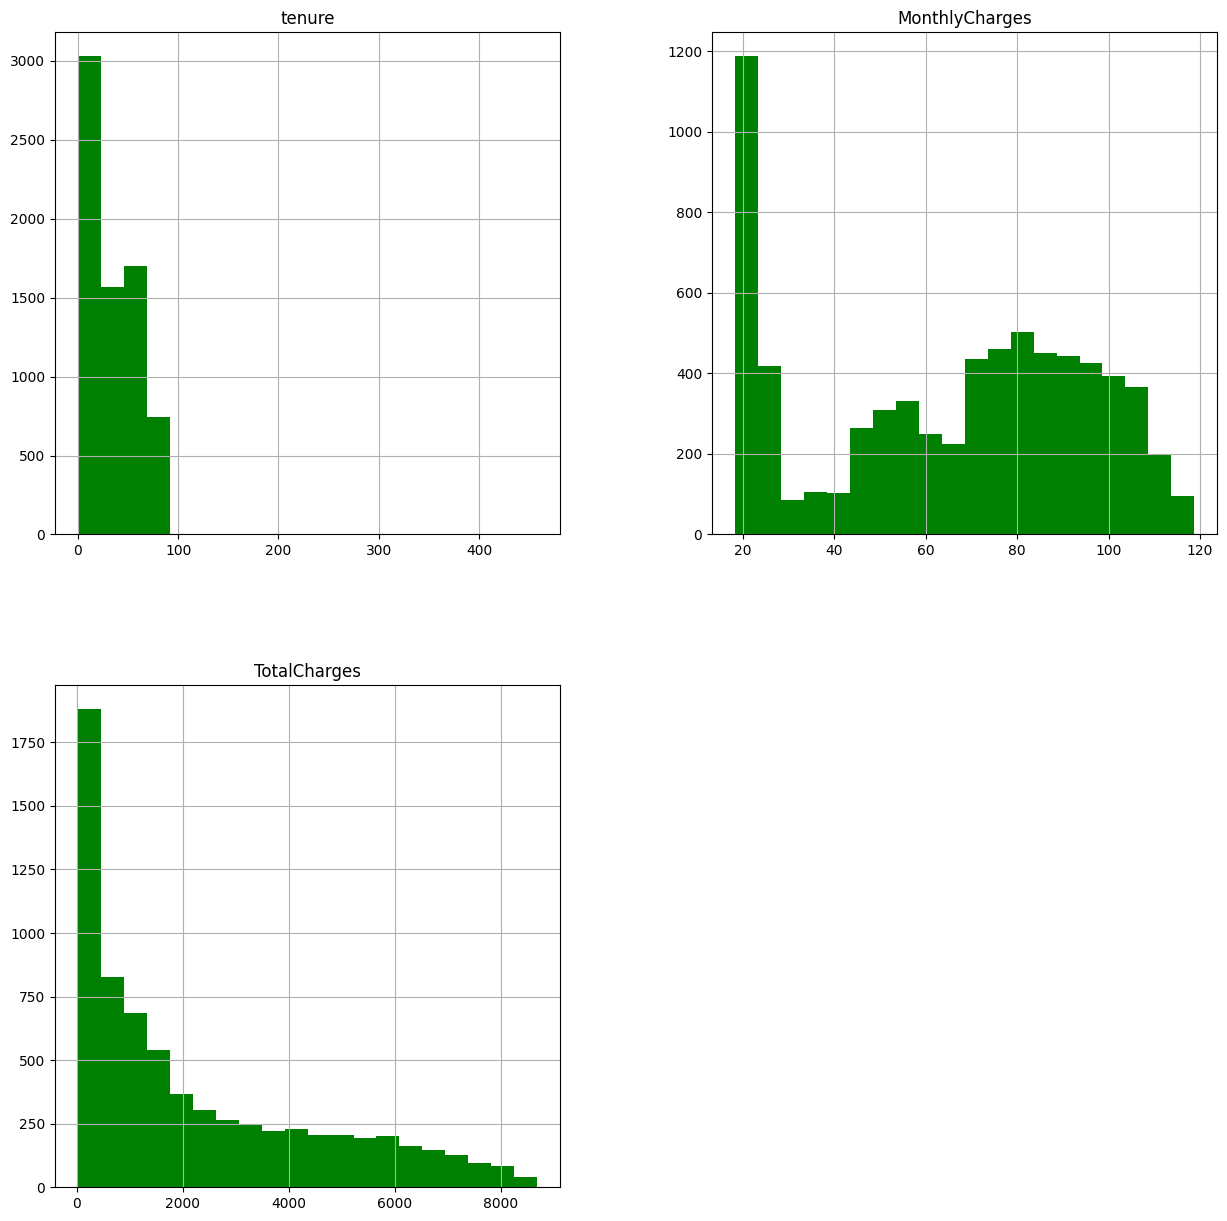

In [13]:
#visualisation des donnees numeriques dans un histograme
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df_numerical.hist(ax = ax,bins = 20, color="g")
plt.show()

Matrice de Correllation


In [14]:
df_numerical.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Vérifions le nombre de valeurs uniques pour chaque variable qualitative

In [15]:
for column in categorical_cols:
  df.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Recherche des valeurs manquantes dan notre jeu de donnees


In [16]:

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

# **Pre-Traitement des donnees**







## **Gestion des valeurs manquantes**

In [17]:
#liste de la colonne ayant des valeur manquantes
col_with_missing_values = ['TotalCharges']

In [18]:
#Création de notre Imputer
imputer = Imputer(inputCols=col_with_missing_values, outputCols=col_with_missing_values).setStrategy("mean")
#Remplacer les valeurs manquantes par notre imputer
imputer=imputer.fit(df)
df = imputer.transform(df)


In [19]:
#verification
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

## **Suppression des valeurs abberantes**

In [20]:
#Recherce des clients avec Tenure superieure a 100
df.filter(col('tenure')>100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [21]:
print("Avant la suppression des valeurs abberantes",df.count())
df_clean= df.filter(df.tenure<100)
print("Apres la suppression des valeurs abberantes",df_clean.count())


Avant la suppression des valeurs abberantes 7043
Apres la suppression des valeurs abberantes 7042


# **Preparation des donnees**

### **Transformation des Variables Numériques**

Assemblage Vectoriel

In [22]:
numerical_vect_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_vect_assembler")
df_clean = numerical_vect_assembler.transform(df_clean)
df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Standardisation

In [23]:
scaler = StandardScaler(inputCol = "numerical_vect_assembler", outputCol = "numerical_feature_scale", withStd=True,withMean=True)
df_clean = scaler.fit(df_clean).transform(df_clean)
df_clean.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+-----------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_vect_assembler|numerical_feature_scale|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+-----------------------+
|7590-VHVEG|Female|

## **Transformation des variables categorielles**

Indexage des strings


In [24]:
categorical_cols_indexed = [name + "_index" for name in categorical_cols]
string_indexer = StringIndexer(inputCols=categorical_cols,outputCols=categorical_cols_indexed)
df_clean=string_indexer.fit(df_clean).transform(df_clean)
df_clean.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+-----------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges

In [25]:
categorical_cols_indexed

['customerID_index',
 'gender_index',
 'SeniorCitizen_index',
 'Partner_index',
 'Dependents_index',
 'PhoneService_index',
 'MultipleLines_index',
 'InternetService_index',
 'OnlineSecurity_index',
 'OnlineBackup_index',
 'DeviceProtection_index',
 'TechSupport_index',
 'StreamingTV_index',
 'StreamingMovies_index',
 'Contract_index',
 'PaperlessBilling_index',
 'PaymentMethod_index',
 'Churn_index']

Suppression des colonnes CustomeId et Churn_index dans la liste des variables categorielles

In [26]:
categorical_cols_indexed.remove("customerID_index")
categorical_cols_indexed.remove("Churn_index")

Combinaison des variables categorielles dans un seul vecteur

In [27]:
categorical_Cols_vect_assembler = VectorAssembler(inputCols=categorical_cols_indexed, outputCol="categorical_Cols_vect_assembler")
df_clean = categorical_Cols_vect_assembler.transform(df_clean)
df_clean.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+-----------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+-------------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_vect_assembler|numeri

Groupage des vecteurs

In [28]:
all_features_vect_assembler = VectorAssembler(inputCols=["numerical_feature_scale","categorical_Cols_vect_assembler"], outputCol="all_features_vect_assembler")
df_clean = all_features_vect_assembler.transform(df_clean)
df_clean.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------------+-----------------------+----------------+------------+-------------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+-------------------------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|num

# **Modele d'entrainement**

Division de notre Dataset en donnees d'entrainement(70%)et de test(30%)

In [29]:
train, test = df_clean.randomSplit([0.7, 0.3], seed =100)
print("Taille de notre donnees d'entrainement:",train.count())
print("Taille de notre donnees de test:",test.count())

Taille de notre donnees d'entrainement: 4930
Taille de notre donnees de test: 2112


Creation et entrainement du Modele de machine learning **Arbre de decision**

In [30]:
#Creation du ML model
decision_tree = DecisionTreeClassifier(labelCol="Churn_index",featuresCol="all_features_vect_assembler", maxDepth=6)
#Entrainement du ML model
model = decision_tree.fit(train)

Prediction sur les donnees de test

In [31]:
prediction = model.transform(test)
prediction.select(["Churn_index","prediction"]).show()

+-----------+----------+
|Churn_index|prediction|
+-----------+----------+
|        1.0|       1.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       1.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       1.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
+-----------+----------+
only showing top 20 rows



# **Evaluation du Modele**

In [32]:
evaluator =BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn_index")

Calcul de l'aire sous la courbe ROC pour les donnees
 de test

In [33]:
auc_test= evaluator.evaluate(prediction,{evaluator.metricName: "areaUnderROC"})
print("Aire sous la courbe ROC pour les donnees de test:",auc_test)

Aire sous la courbe ROC pour les donnees de test: 0.7096018110810186


Calcul de l'aire sous la courbe ROC pour les donnees
 de d'entrainement

In [34]:
prediction_train = model.transform(train)
auc_train= evaluator.evaluate(prediction_train,{evaluator.metricName: "areaUnderROC"})
print("Aire sous la courbe ROC pour les donnees d'entrainement:",auc_train)

Aire sous la courbe ROC pour les donnees d'entrainement: 0.7269490254872564


## **Amelioration des performance du modele** *Réglage des hyperparamètres*

Trouvons le meilleur paramètre maxDepth pour notre modèle Arbre de decision.

In [35]:
def find_best_maxDepth(params):
  accuracies_train = []
  accuracies_test = []
  for param in params:
    decision_tree = DecisionTreeClassifier(labelCol="Churn_index",featuresCol="all_features_vect_assembler",maxDepth=param)
    decision_tree_model = decision_tree.fit(train)
    #calcul des erreurs test
    prediction_test = decision_tree_model.transform(test)
    evaluator =BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn_index")
    auc_test= evaluator.evaluate(prediction_test,{evaluator.metricName: "areaUnderROC"})
    #recording test accuracy
    accuracies_test.append(auc_test)
    #calcul des erreurs train
    prediction_train = decision_tree_model.transform(train)
    auc_train= evaluator.evaluate(prediction_train,{evaluator.metricName: "areaUnderROC"})
    accuracies_train.append(auc_train)
  return accuracies_train, accuracies_test


In [36]:
maxDepths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
accuracies_train, accuracies_test = find_best_maxDepth(maxDepths)
print(accuracies_train)
print(accuracies_test)

[0.5, 0.7113943028485756, 0.662590075929777, 0.7025317986168206, 0.743186874304783, 0.7269490254872564, 0.7422014799052086, 0.7733048798181555, 0.8135428253615127, 0.8344537408714998, 0.8536659089809935, 0.8848478986313295, 0.9144399574406346, 0.9312037529622286, 0.9503796488852349, 0.9611706243652367, 0.9713751994970257, 0.9737812545340233, 0.9770457513178894, 0.9808785123567249]
[0.5, 0.7323855184634258, 0.6568119995970108, 0.6879055819934928, 0.743615287515038, 0.7096018110810186, 0.7092515660280079, 0.7047131961194507, 0.7279615263809789, 0.6936825511588903, 0.6783292540550792, 0.686323849258322, 0.6822020990997931, 0.6849560563947872, 0.6774628272065141, 0.6674497300564778, 0.66838430949573, 0.6665649316399884, 0.6568688921944541, 0.6609242676559657]


Visualisation

In [37]:
df =pd.DataFrame({"maxDepth":maxDepths,"accuracies_train":accuracies_train,"accuracies_test":accuracies_test})
df

,maxDepth,accuracies_train,accuracies_test
0,1,0.500000,0.500000
1,2,0.711394,0.732386
2,3,0.662590,0.656812
3,4,0.702532,0.687906
4,5,0.743187,0.743615
5,6,0.726949,0.709602
6,7,0.742201,0.709252
7,8,0.773305,0.704713
8,9,0.813543,0.727962
9,10,0.834454,0.693683


In [38]:
px.line(df,x= "maxDepth", y= ["accuracies_train", "accuracies_test"])

# **Deploiement du  Modele**

In [39]:
importance_features = model.featureImportances
scores =[score for i, score in enumerate(importance_features)]
df =pd.DataFrame(scores, columns=["score"],index=categorical_cols_indexed +  numerical_cols)
df

,score
gender_index,0.207538
SeniorCitizen_index,0.013851
Partner_index,0.005029
Dependents_index,0.001246
PhoneService_index,0.005062
MultipleLines_index,0.000000
InternetService_index,0.005199
OnlineSecurity_index,0.013661
OnlineBackup_index,0.018870
DeviceProtection_index,0.145657


In [40]:
px.bar(df,y="score")

Visualisation Taux de désabonnement des clients par période d'occupation

In [41]:
df =df_clean.groupby(["tenure","Churn"]).count().toPandas()
df

,tenure,Churn,count
0,46,Yes,12
1,27,No,59
2,15,Yes,37
3,60,No,70
4,71,Yes,6
...,...,...,...
140,64,No,76
141,9,No,73
142,53,Yes,14
143,18,Yes,24


In [42]:
px.bar(df,x="tenure",y="count",color="Churn")